In [1]:
%load_ext autoreload
%autoreload 2
import ruamel.yaml as yaml
import os
import sys
os.chdir('..')
print(os.getcwd())
import sys
import json
import pickle
from utils.file_handling import MultiOutput, load_model_from_config
from evaluation.vizualizations import tsne_plot, correlation_plot
from experiment import *
from evaluation.topics import get_topics, npmi_coherence_score, print_top_words, get_most_correlated_topics

/home/dorian/FER/master_thesis/src/base


In [21]:
MODEL_PATH = 'results/20news/notebooks/hfvae/a_1/'
SAVE_PATH = MODEL_PATH
config_path = os.path.join(MODEL_PATH, 'config.yaml')
config = yaml.safe_load(open(config_path, 'r'))
data_path = config['experiment_parameters']['data_path']
model = load_model_from_config(config_path, weights_path=os.path.join(MODEL_PATH, 'model.pt'))
model.eval()
experiment = experiments[config['experiment_parameters']['name']](model, config['experiment_parameters'])

#### TSNE

In [22]:
zs, z_mus = experiment.sample_latent(experiment.test_dataloader())
ys = np.load(os.path.join(data_path, 'test.labels.npy'))[:zs.shape[0]]
labels = json.load(open(os.path.join(data_path, 'labels.json'), 'r'))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

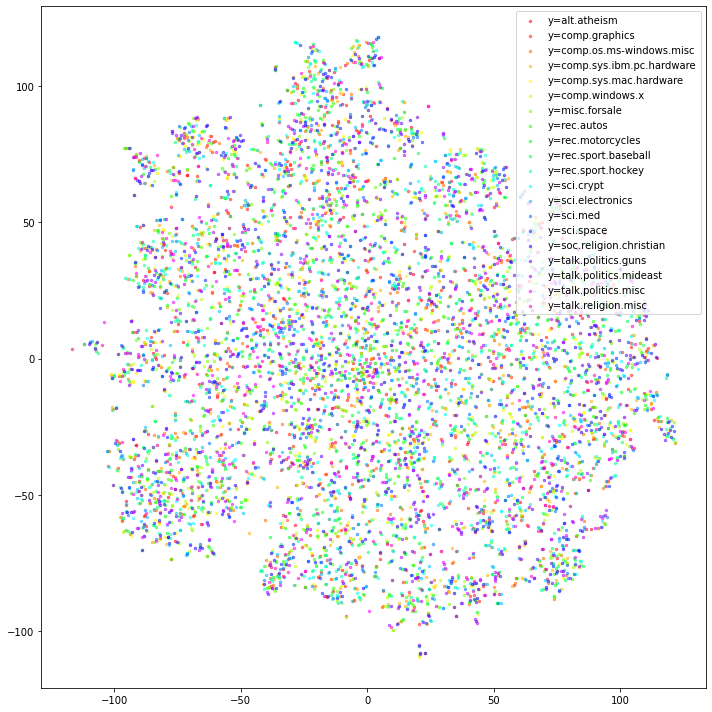

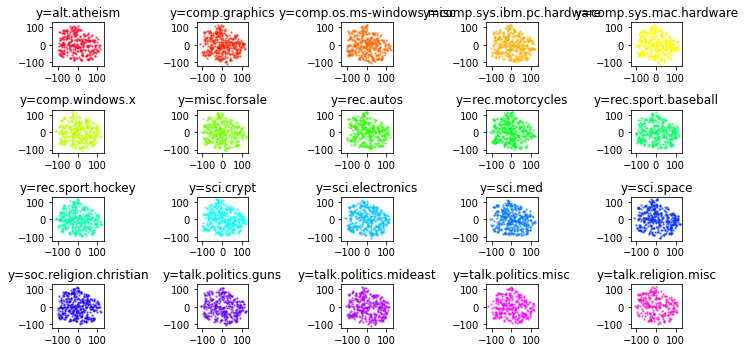

In [26]:
tsne_plot(z_mus, ys, labels, show=True, save_path=SAVE_PATH, plot_by_class=True,
          perplexity=10, learning_rate=200, n_iter=2000, n_jobs=-1)

#### Correlation plot

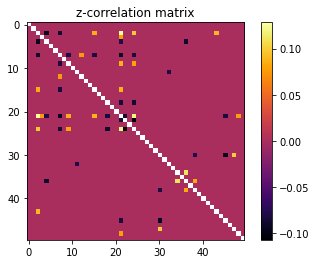

In [23]:
correlation_plot(zs, show=True, save_path=SAVE_PATH)


#### Topics

In [24]:
n_top = 10
vocab = json.load(open(os.path.join(data_path, 'vocab.json'), 'r'))
idx2word = {i: vocab[i] for i in range(len(vocab))}
beta = model.decoder.main[0].weight.cpu().detach().numpy().T
topics = get_topics(beta, idx2word, n_top=n_top)
print_top_words(beta, idx2word, n_top=n_top, save_path=os.path.join(SAVE_PATH, 'topics.txt'))



--------------- Topics ------------------
shuttle relative fuel engine nasa keith ken select vehicle turbo
crypto roger criminals games rangers firearms sale yeah dealers chips
citizens government killed drugs surrender human anti americans state society
max die koresh year deleted jesus hell food military winning
running mac run problem machine directory window file convert windows
period telephone national annual april industry los officials louis turkish
pages motif copies max resource map widget committee volume annual
objects disks button unit screen storage font postscript location hole
israeli status school news international hospital education islamic mary arab
people public message law part fact response simply called method
sexual evidence homosexuality stats patients occurs percentage homosexual report impact
detroit toronto bible adams lord won universe god wings max
van boards game period included max pub sun fax arab
max chips keys chip key escrow serial clock bits clippe

#### NPMI

In [25]:
word_frequencies = pickle.load(open(os.path.join(data_path, 'word_frequencies.pkl'), 'rb'))
joint_word_frequencies = pickle.load(open(os.path.join(data_path, 'jointword_frequencies.pkl'), 'rb'))
npmi_per_topic = npmi_coherence_score(topics, word_frequencies, joint_word_frequencies)
print(npmi_per_topic)
print(sum(npmi_per_topic) / len(npmi_per_topic))
print('Max: %f' % max(npmi_per_topic))
print('Topic : %s' % (' '.join(topics[np.argmax(npmi_per_topic)])))
# save results
json.dump({'npmi_per_topic': npmi_per_topic, 'avg_npmi': sum(npmi_per_topic) / len(npmi_per_topic),
           'topics': topics},
          open(os.path.join(SAVE_PATH, 'npmi.json'), 'w'), indent=4)

[0.17763697941966494, -0.1462931820660771, 0.26574395549913954, 0.025643930721655325, 0.2748795325680812, 0.3111734788612345, 0.2639727156683582, 0.28660380327955226, 0.1589788605976466, 0.24821478304510952, 0.2034038034885484, 0.01546925848067293, 0.1023190711678427, 0.28231185032944006, 0.2934206463511108, 0.2843304474939018, 0.1478836569485621, 0.310060749402902, 0.2987004334574362, 0.1740554105129129, 0.15675947072149088, 0.20956759601703695, 0.22326843745399122, 0.2297943713816305, 0.14485218739785882, 0.3503955309549332, 0.08885455135553269, 0.0029486183714968954, 0.22775236416753566, 0.21446121648923655, 0.18783117795008214, 0.22630099444691187, 0.22763685061869576, 0.028179488517884908, 0.2920681491918789, -0.12409675634202251, 0.43805221132414174, 0.17505221633218182, 0.2663385333340976, 0.2390684833420894, 0.28603389892558323, 0.24537823055672497, 0.11891580653225277, 0.19304566472308307, 0.19576501546456007, 0.13212752203472447, 0.13447324990766243, 0.20250095966488782, 0.34

#### Most correlated topics

In [16]:
inds, covs, cor_topics = get_most_correlated_topics(np.corrcoef(zs.T), top_correlations=4)
for topic in cor_topics:
    print('%d %f %s' % (topic, npmi_per_topic[topic], topics[topic]))

NameError: name 'npmi_per_topic' is not defined